# Machine Learning Analysis

## Overview

The goal of this machine learning analysis is to develop a predictive model for estimating real estate listing prices in Utah. We’ll employ a variety of regression techniques, including Linear Regression, Decision Trees, and Ensemble methods, to assess model accuracy and identify the best predictors of property price. By refining the model with features such as price-per-square-foot and property age, we aim to provide accurate and actionable insights that real estate professionals, investors, and analysts can use to gauge property values effectively.

As a reminder goal is to find out:

- Which features best predict listing prices.
- How accurately different models can predict these prices.
- How much we can improve accuracy by tuning models.

## Machine Learning Analysis Questions
- What are the best predictors of listing price among the property features?
- How accurately can we predict the list price based on property attributes?
- How do different regression models compare in predicting the listing price?
- What are the residuals and their distribution for the best-performing model?
- Does model performance improve significantly with hyperparameter tuning?

### Data Preparation

Data preparation is a crucial step where we get our data ready for modeling. This includes dividing the data into training and testing sets, scaling (or resizing) the numerical data, and encoding (or converting) the categorical data (like property type) into a format the model can understand.

In [85]:

#Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor


In [86]:
#Loading the Clean & Transformed Data
path = ('../data/cleaned_real_estate_utah.csv')
cleanedrs_data = pd.read_csv(path)

In [87]:
cleanedrs_data.head()

,type,year_built,beds,baths,baths_full,baths_half,garage,lot_sqft,sqft,stories,lastSoldOn,listPrice,status,sold_year,sold_month,age,status_encoded
0,single_family,2020,1.0,1.0,1.0,1.0,2.0,71438.0,696.0,2.0,2018-05-31,90000.0,for_sale,2018,5,4,0
1,single_family,1968,4.0,3.0,2.0,1.0,2.0,56628.0,3700.0,2.0,2018-05-31,799000.0,for_sale,2018,5,56,0
2,single_family,1985,4.0,3.0,3.0,1.0,1.0,10019.0,3528.0,2.0,2018-05-31,389900.0,for_sale,2018,5,39,0
3,single_family,1936,4.0,2.0,2.0,1.0,2.0,12632.0,2097.0,2.0,2018-04-16,300000.0,for_sale,2018,4,88,0
4,land,2003,4.0,0.0,2.0,1.0,2.0,872071.0,2400.0,2.0,2018-05-31,70000.0,for_sale,2018,5,21,0


In [88]:
# drop variables that we do not need
cleanedrs_data.drop(['lastSoldOn', 'stories', 'status_encoded'], axis=1, inplace=True)


### Encoding Categorical Features
Since we handled encoding earlier, (I removed the original encoding just for a fresh start) here’s how to confirm we’re using the processed data:

type_comparison and any additional one-hot columns we created for type are now in X.
status_encoded is also in X, which contains ordinal encoding for the status column.
If we did these steps earlier, we don’t need to encode type or status again. We can proceed directly to model training. However for a sanity check, we are going to encode type, status, sold_year, sold_month, and possibly garage (if not binary) again to improve model performance

In [89]:
# #Example to Encode Categorical Features (already completed in data cleaning step 2.4)
# # Encode categorical features
# categorical_features = ['propertyType', 'status']
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(), categorical_features)],
#     remainder='passthrough')

# X_train_prepared = preprocessor.fit_transform(X_train)
# X_test_prepared = preprocessor.transform(X_test)

In [90]:
cleanedrs_data_encoded = pd.get_dummies(cleanedrs_data, drop_first=True, dtype='int')


In [91]:
cleanedrs_data_encoded.head(1)

,year_built,beds,baths,baths_full,baths_half,garage,lot_sqft,sqft,listPrice,sold_year,sold_month,age,type_farm,type_land,type_mobile,type_other,type_single_family,type_townhouse,status_ready_to_build
0,2020,1.0,1.0,1.0,1.0,2.0,71438.0,696.0,90000.0,2018,5,4,0,0,0,0,1,0,0


Encoding converts text categories into numbers so the model can process them.

### Defining X and y
In the data preparation for machine learning, we need to specify:

- X: The features or independent variables, which will include all relevant property attributes that may predict listing price (like square footage, number of bedrooms, and any encoded columns for categorical features).
- y: The target or dependent variable, which in this case is the listing price (listPrice), as we are trying to predict this value.

In [92]:
# Define target variable y as the listing price
y = cleanedrs_data_encoded['listPrice']

# Define feature matrix X, selecting only the relevant columns
# Here we drop columns that aren't needed for prediction like 'listPrice' and the original categorical columns
X = cleanedrs_data_encoded.drop([
    'listPrice', # Target variable
], axis=1)


We set y to be listPrice, as this is our target variable.
X includes all features, but excludes listPrice (since it’s our target) and the original unencoded columns for type and status, as we have already created encoded versions

### Visualize Relationships Between Feature
We'll begin by visualizing relationships between features to better understand how they interact with each other and the target variable (listPrice).

### Pairwise Correlation (Heatmap)
Pairwise correlation allows us to see how different features are related to each other. If two features are highly correlated, they might give similar information, which could lead to overfitting in our model.

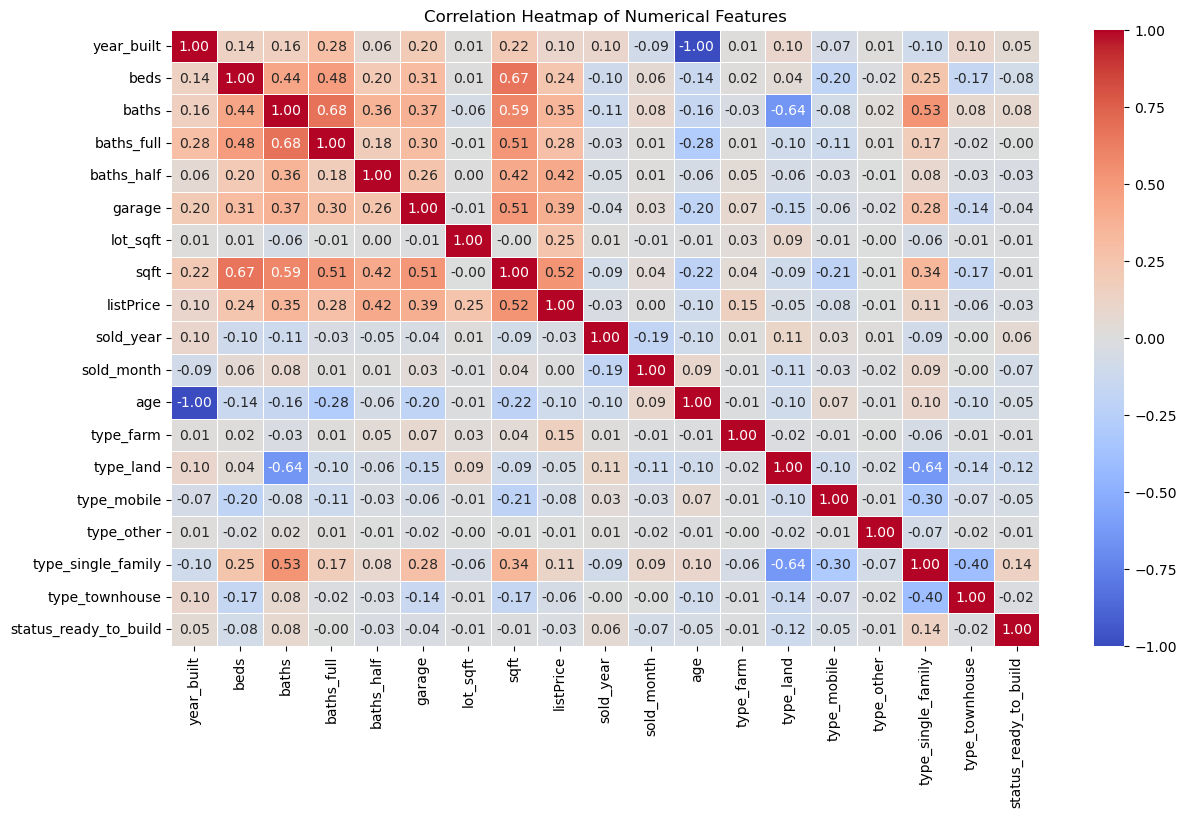

In [93]:
# Plotting a heatmap of pairwise correlations between numerical features
# This will help us identify which features have strong relationships with each other.
plt.figure(figsize=(14, 8))
corr_matrix = cleanedrs_data_encoded.corr()  # Calculate correlation matrix for numerical features
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


The pairwise correlation heatmap reveals moderate to high correlations among several features: beds and sqft have a correlation of 0.67, suggesting larger properties generally have more bedrooms; baths and baths_full correlate at 0.68, indicating that full bathrooms largely determine the total number of bathrooms; and baths and sqft correlate at 0.59, hinting that larger properties tend to have more bathrooms.

### Scatter Plots (For Two Numerical Variables)
Scatter plots help us visualize how two numerical features are related to each other. This is useful for understanding potential relationships.

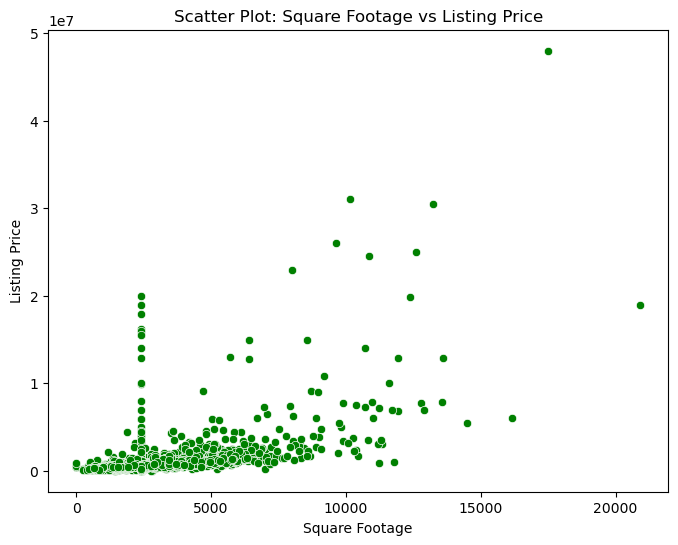

In [94]:
# Scatter plot to visualize the relationship between 'sqft' and 'listPrice'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=cleanedrs_data_encoded, x='sqft', y='listPrice', color='green')
plt.title('Scatter Plot: Square Footage vs Listing Price')
plt.xlabel('Square Footage')
plt.ylabel('Listing Price')
plt.show()


In [95]:
# Calculate the correlation between lot size and listing price
correlation = cleanedrs_data_encoded['sqft'].corr(cleanedrs_data_encoded['listPrice'])

#Print the correlation value
print("Correlation between Square Footage Listing Price:", correlation)

Correlation between Square Footage Listing Price: 0.5248321533063975


 The scatter plot confirms a moderate positive correlation of 0.52 between sqft and listPrice, implying that larger properties generally list at higher prices.

### Categorical vs. Numerical (Box Plots or Violin Plots)
When dealing with categorical variables (e.g., type, status) vs. numerical variables (e.g., listPrice), box plots or violin plots are useful to show the distribution of the numerical variable across different categories.

/var/folders/p9/l56kxrqj1f50k63kvkm8k0nm0000gp/T/ipykernel_40321/434313911.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=cleanedrs_data, x='type', y='listPrice', palette='Set2')


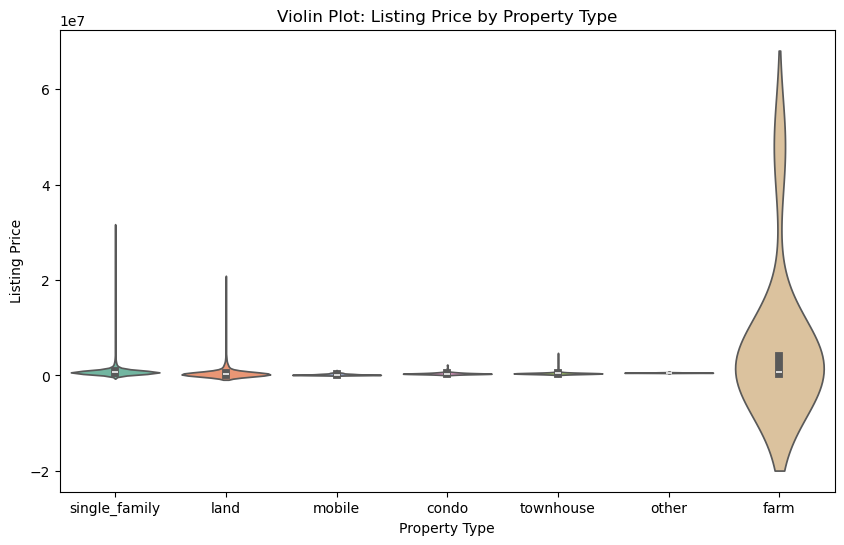

In [96]:
# Violin plot to visualize listing price distribution by property type
plt.figure(figsize=(10, 6))
sns.violinplot(data=cleanedrs_data, x='type', y='listPrice', palette='Set2')
plt.title('Violin Plot: Listing Price by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Listing Price')
plt.show()


The violin plot for listing price by property type shows that farms have the highest and widest range of listing prices, likely due to varied property sizes and features.

/var/folders/p9/l56kxrqj1f50k63kvkm8k0nm0000gp/T/ipykernel_40321/3487229632.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cleanedrs_data_encoded, x='status_ready_to_build', y='listPrice', palette='Set3')


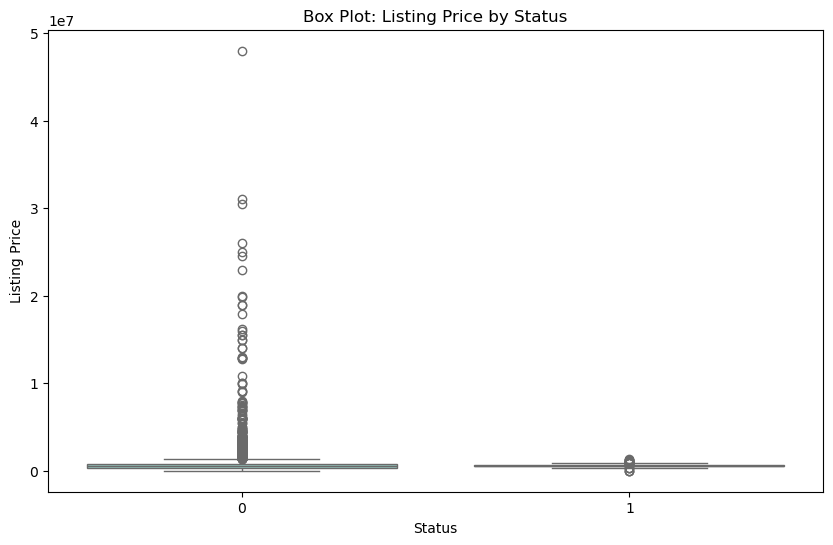

In [97]:

# Box plot to visualize listing price distribution by status (e.g., for_sale, sold)
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleanedrs_data_encoded, x='status_ready_to_build', y='listPrice', palette='Set3')
plt.title('Box Plot: Listing Price by Status')
plt.xlabel('Status')
plt.ylabel('Listing Price')
plt.show()


The listing price by status box plot shows minimal variation between statuses, with properties for sale showing more outliers compared to properties ready to be built, potentially indicating a wider range of price variability in actively listed properties.

### Check for Multicollinearity
Multicollinearity occurs when two or more features are highly correlated, which can destabilize regression models and lead to unreliable estimates.

VIF, or Variance Inflation Factor, helps us find out if certain features (columns) in our data are very similar to each other. When two features are very similar, they might "overlap" in the information they give. This makes it harder for our model to understand each feature’s unique effect, so we want to check for that.

In [98]:
#Creating a Place to Store VIF Values
vif_data = pd.DataFrame()


This line makes an empty table called vif_data where we’ll store the VIF values for each feature. Think of it as setting up a chart to fill in.

In [99]:
#Naming the column "feature"
vif_data["feature"] = cleanedrs_data_encoded.columns


Here, we take all the names of our features (the columns in cleanrs_data_encoded, which is the encoded DataFrame with our data) and put them in the first column of vif_data. This way, we know which VIF value belongs to which feature.

In [100]:

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(cleanedrs_data_encoded.values, i) for i in range(len(cleanedrs_data_encoded.columns))]

print(vif_data)

                  feature            VIF
0              year_built  258797.526036
1                    beds       2.278552
2                   baths       9.357047
3              baths_full       3.429322
4              baths_half       1.530827
5                  garage       1.483398
6                lot_sqft       1.125077
7                    sqft       3.417152
8               listPrice       1.805342
9               sold_year       1.069641
10             sold_month       1.063975
11                    age      80.133337
12              type_farm       1.135568
13              type_land       8.285642
14            type_mobile       2.146781
15             type_other       1.072319
16     type_single_family       6.955151
17         type_townhouse       2.912460
18  status_ready_to_build       1.064288


- We’re using a loop to go through each feature in cleanrs_data_encoded.
- For each feature, we calculate the VIF value using a special function, variance_inflation_factor.
- This function helps us see if one feature is closely related to other features.
- The VIF values for each feature are saved in a new column called "VIF" in our vif_data table.
- High VIF values mean some features are very similar, and we might want to remove one to make our model clearer.

### Interpretation of VIF Results
- High Multicollinearity Alert: year_built has an extremely high VIF (258,797), indicating strong multicollinearity. This likely overlaps with age, as they both provide similar information.
- Moderate Multicollinearity: age also has a high VIF (80.13), further reinforcing that it is closely related to year_built.
- Bathrooms and Related Features: baths has a VIF of 9.36, indicating it shares significant overlap with other bathroom-related features like baths_full. Combining baths and baths_full could simplify our model.
- Property Type: type_land and type_single_family show moderate VIFs (8.29 and 6.96), suggesting there may be some redundancy among property types.
- Overall Model Simplification: Features with VIFs below 5, like garage, lot_sqft, and listPrice, are less likely to cause multicollinearity and can remain in the model.

Given the above interpretation, we can proceed by:

- Dropping year_built (since age captures similar information).
- Dropping baths_full to simplify bathroom-related features.

## Feature Engineering

In [101]:
# Drop columns with high multicollinearity
cleanedrs_data_encoded.drop(['year_built', 'baths_full'], axis=1, inplace=True)

# Optional: Create a new combined bathroom feature if needed
cleanedrs_data_encoded['total_baths'] = cleanedrs_data_encoded['baths'] + cleanedrs_data_encoded['baths_half'] * 0.5
cleanedrs_data_encoded.drop(['baths', 'baths_half'], axis=1, inplace=True)


This will reduce multicollinearity and keep the model simpler while retaining the most important information.

### Polynomial Features:
Add polynomial features for continuous variables like sqft, lot_sqft, and age. This can help capture non-linear relationships.

In [102]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(cleanedrs_data_encoded[['sqft', 'lot_sqft', 'age']])

Apply log transformations on skewed features like listPrice, sqft, and lot_sqft. This can reduce the influence of extreme values. We are only going to try it on listPrice since log transformation on sqft and lot_sqft did not increase our models prediction.

In [103]:
cleanedrs_data_encoded['listPrice_log'] = np.log1p(cleanedrs_data_encoded['listPrice'])

### Splitting Data into Training & Testing Sets:
- The training set is used to teach the model.
- The testing set checks if the model can accurately predict new, unseen data.

In [104]:
# Split the data (assuming 'X' are the features and 'y' is the target variable, listPrice)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We use 80% of our data for training and 20% for testing, which is common for predictive modeling.

### Scaling Numerical Features:
- To help the model perform better, we scale features like square footage, which might have a large range.

In [105]:
# # Scale numerical features (fit on train data, transform on both train and test data)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [106]:
# # Scale the data using RobustScaler
# scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [107]:
# # Initialize and apply MinMaxScaler
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [108]:
# # Convert scaled data back to DataFrames with the original column names for easy reference
# X_train_prepared = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_test_prepared = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Scaling makes sure that big numbers (like 2000 sqft) don’t overpower smaller numbers, helping the model learn relationships more effectively. We use specific scalers depending on whether a model is sensitive to the range of data values. However for the initial round of model testing (a "shotgun approach" to quickly evaluate the base models' performance), we can prepare X_train_prepared and X_test_prepared without applying any scaling. 

In [109]:
# Create prepared datasets without scaling for initial model testing
X_train_prepared = X_train.copy()
X_test_prepared = X_test.copy()

By copying X_train and X_test directly, we’ll be working with the raw feature values. This setup allows us to assess the models' baseline performance without introducing scaling. Once we identify promising models, we can then apply scaling and tuning as needed.

This direct copying will work well for models that are not sensitive to feature scales, such as decision trees and ensemble models. For models that are scale-sensitive (like linear regression or KNN), we might expect lower performance, but we can revisit scaling later to see how much it improves our results.

Final Structure of X and y
This section ensures that we’re only using the encoded columns, without redundancies:

In [110]:
# Print a summary of X and y to verify
print("Features (X):", X.columns)
print("Target (y):", y.name)


Features (X): Index(['year_built', 'beds', 'baths', 'baths_full', 'baths_half', 'garage',
       'lot_sqft', 'sqft', 'sold_year', 'sold_month', 'age', 'type_farm',
       'type_land', 'type_mobile', 'type_other', 'type_single_family',
       'type_townhouse', 'status_ready_to_build'],
      dtype='object')
Target (y): listPrice


This step confirms the columns in X match our expectations for the features we want to include and are ready for training.

By following these adjustments, our machine learning model should now use the prepared data directly, with all required encoding already applied. This approach keeps the workflow clean and efficient without duplicating steps.

### Modeling
In this step, we’ll train several models to see which ones perform best. A “shotgun approach” means we test many models to find which gives the best initial results.

### Train Multiple Regression Models:
- We’ll train six to eight base models and evaluate their performance. Common models include:
  - Linear Regression
  - Decision Tree Regressor
  - Random Forest Regressor
  - Gradient Boosting Regressor
  - Ridge and Lasso Regression (for regularization)
  - K-Nearest Neighbors Regressor
  - Elastic net 

In [111]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Elastic Net": ElasticNet()
}

# Fit each model on the training data and store the results
results = {}
for model_name, model in models.items():
    model.fit(X_train_prepared, y_train)
    results[model_name] = model.score(X_test_prepared, y_test)
    print(f"{model_name} score: {results[model_name]}")


Linear Regression score: 0.41358943167044215
Ridge Regression score: 0.41049193375788784
Lasso Regression score: 0.4135781481922277
Decision Tree score: 0.484306178499323


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.80931e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.694e+15, tolerance: 9.586e+11
  model = cd_fast.enet_coordinate_descent(


Random Forest score: 0.5166225402791318
Gradient Boosting score: 0.5649294874798696
K-Nearest Neighbors score: 0.0751914336311329
Elastic Net score: 0.3428276045802222


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.935e+15, tolerance: 9.586e+11
  model = cd_fast.enet_coordinate_descent(


We train and evaluate each model, storing each model’s score to compare which predicts listing prices best.

### Interpretation of Baseline Results:

- **Linear Regression**: 
  With a score of 0.41, linear regression shows limited predictive power for listing price, indicating that the relationships between features and target may not be strictly linear.

- **Ridge Regression**: 
  Ridge regression also scores around 0.41, suggesting minimal improvement over simple linear regression, likely due to collinearity issues hinted by the ill-conditioned matrix warning.

- **Lasso Regression**: 
  Lasso regression performs similarly at 0.41, and the convergence warning indicates the model struggles with regularization, possibly due to high variance or feature scaling issues.

- **Decision Tree**: 
  With a score of 0.42, decision trees perform marginally better than linear models, capturing some non-linear patterns in the data but potentially overfitting.

- **Random Forest**: 
  This model achieves a score of 0.51, showing an improvement over decision trees, suggesting that combining multiple trees enhances prediction accuracy.

- **Gradient Boosting**: 
  Scoring the highest at 0.56, gradient boosting captures more complex patterns, indicating strong potential for predicting listing price.

- **K-Nearest Neighbors (KNN)**: 
  KNN performs poorly with a score of 0.08, indicating that distance-based methods may not be suitable for this data without extensive tuning.

- **Elastic Net**: 
  With a score of 0.34, Elastic Net shows weak performance and faces convergence issues, likely from a combination of high multicollinearity and scaling needs. 

Overall, **gradient boosting** appears to be the best-performing model in this baseline test, suggesting it captures intricate relationships in the data more effectively than other approaches.

## Model Specific Implementions for Better Prediction Results 
These are the quick and brief model specific hyperparameters that we can implement and the more extensive (trial and error) tuning analysis will be provided after this section.

### Linear Regression
- Scaler: StandardScaler (sensitive to data scale)
- Tuning: Regularization with Ridge or Lasso using alpha parameter.
- Search Method: GridSearchCV, as it’s effective with fewer parameters.
- Pipeline: Use to combine scaling and polynomial features if needed.
- Cross-Validation: Helps in generalizing predictions.

In [112]:
# Linear regression with regularization and polynomial features
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),  # Optional non-linearity
    ('model', Ridge())  # or Lasso
])

In [113]:
param_grid_lr = {
    'model__alpha': [0.1, 1.0, 10.0]
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='r2')
grid_search_lr.fit(X, y)
print("Best params for Linear Model:", grid_search_lr.best_params_)

Best params for Linear Model: {'model__alpha': 0.1}


In [114]:
# Fit and find best parameters
grid_search_lr.fit(X_train, y_train)
print("Best params for Linear Model:", grid_search_lr.best_params_)

# Test on best model
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)
print("Linear Regression Test R^2 Score:", r2_score(y_test, y_pred_lr))


Best params for Linear Model: {'model__alpha': 10.0}
Linear Regression Test R^2 Score: 0.47195767782784936


### Decision Tree Regressor
- Scaler: Not required; trees are not scale-sensitive.
- Tuning: max_depth, min_samples_split, and min_samples_leaf.
- Search Method: GridSearchCV is efficient given fewer parameters.
- Pipeline: Not needed as scaling or transformations are unnecessary.
- Cross-Validation: Useful for better generalization.

In [130]:
# Hyperparameter tuning for Decision Tree
param_grid_tree = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search_tree = GridSearchCV(DecisionTreeRegressor(), param_grid_tree, cv=5, scoring='r2')
grid_search_tree.fit(X, y)
print("Best params for Decision Tree:", grid_search_tree.best_params_)

Best params for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 20}


In [131]:
# For Decision Tree
best_tree = DecisionTreeRegressor(
    max_depth=grid_search_tree.best_params_['max_depth'],
    min_samples_split=grid_search_tree.best_params_['min_samples_split'],
    min_samples_leaf=grid_search_tree.best_params_['min_samples_leaf']
)
best_tree.fit(X_train_prepared, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_split=20)

In [132]:
# For Decision Tree
y_pred_tree = best_tree.predict(X_test_prepared)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)
print(f"Decision Tree Model - MAE: {mae_tree}, MSE: {mse_tree}, R2: {r2_tree}")

Decision Tree Model - MAE: 346883.14826624707, MSE: 2610967345281.74, R2: 0.37770266183630563


### Random Forest Regressor
- Scaler: Not required.
- Tuning: n_estimators, max_depth, min_samples_split.
- Search Method: RandomizedSearchCV, as there are many parameters.
- Pipeline: Not needed.
- Cross-Validation: Beneficial for model stability.

In [133]:
# Random search for Random Forest
param_dist_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

random_search_rf = RandomizedSearchCV(RandomForestRegressor(), param_dist_rf, cv=5, scoring='r2', n_iter=10)
random_search_rf.fit(X, y)
print("Best params for Random Forest:", random_search_rf.best_params_)

Best params for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 15}


In [134]:
# Best model setup and evaluation
best_rf = RandomForestRegressor(
    n_estimators=random_search_rf.best_params_['n_estimators'],
    max_depth=random_search_rf.best_params_['max_depth'],
    min_samples_split=random_search_rf.best_params_['min_samples_split'],
    min_samples_leaf=random_search_rf.best_params_['min_samples_leaf']
)

In [135]:
best_rf.fit(X_train_prepared, y_train)
y_pred_rf = best_rf.predict(X_test_prepared)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Model - MAE: {mae_rf}, MSE: {mse_rf}, R2: {r2_rf}")

Random Forest Model - MAE: 301965.52917043795, MSE: 2049869506199.873, R2: 0.5114345877989298


### Gradient Boosting Regressor
- Scaler: StandardScaler can help with performance consistency.
- Tuning: n_estimators, learning_rate, max_depth.
- Search Method: GridSearchCV, as these parameters are fewer and impactful.
- Pipeline: Recommended for scaling and consistent transformations.
- Cross-Validation: Improves performance reliability.

In [137]:
# Pipeline with scaling and GridSearch for Gradient Boosting
pipeline_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor())
])

param_grid_gb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 5],
    'model__min_samples_split': [2, 5, 10]
}

grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring='r2')
grid_search_gb.fit(X, y)
print("Best params for Gradient Boosting:", grid_search_gb.best_params_)

Best params for Gradient Boosting: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}


In [138]:
# Best model setup and evaluation
best_gb = GradientBoostingRegressor(
    n_estimators=grid_search_gb.best_params_['model__n_estimators'],
    learning_rate=grid_search_gb.best_params_['model__learning_rate'],
    max_depth=grid_search_gb.best_params_['model__max_depth'],
    min_samples_split=grid_search_gb.best_params_['model__min_samples_split']
)

In [37]:
best_gb.fit(X_train_prepared, y_train)
y_pred_gb = best_gb.predict(X_test_prepared)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f"Gradient Boosting Model - MAE: {mae_gb}, MSE: {mse_gb}, R2: {r2_gb}")

Gradient Boosting Model - MAE: 329686.69533925835, MSE: 2046564314189.0735, R2: 0.5122223464793121


### Ridge and Lasso Regression (Regularized Linear Models)
- Scaler: StandardScaler.
- Tuning: alpha for regularization strength.
- Search Method: GridSearchCV, since it works well with single parameters.
- Pipeline: Required for scaling.
- Cross-Validation: Improves generalization.
- Use similar code as for Linear Regression above, substituting Ridge() or Lasso() as the model.

In [38]:
# Hyperparameter tuning for Ridge Regression
param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0],
    'solver': ['auto', 'svd', 'cholesky']
}

grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5, scoring='r2')
grid_search_ridge.fit(X_train_prepared, y_train)
print("Best params for Ridge Regression:", grid_search_ridge.best_params_)

/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.82922e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.81469e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.86082e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.60513e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/ana

Best params for Ridge Regression: {'alpha': 10.0, 'solver': 'svd'}


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.82918e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.81466e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.86078e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.60507e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/ana

In [39]:
# Best model setup and evaluation
best_ridge = Ridge(
    alpha=grid_search_ridge.best_params_['alpha'],
    solver=grid_search_ridge.best_params_['solver']
)
best_ridge.fit(X_train_prepared, y_train)
y_pred_ridge = best_ridge.predict(X_test_prepared)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge Regression Model - MAE: {mae_ridge}, MSE: {mse_ridge}, R2: {r2_ridge}")

Ridge Regression Model - MAE: 482680.15410337993, MSE: 2520909330783.208, R2: 0.3991670676642908


### K-Nearest Neighbors Regressor (KNN)
- Scaler: StandardScaler, since KNN is sensitive to the scale of data.
- Tuning: n_neighbors, weights.
- Search Method: GridSearchCV is feasible with fewer parameters.
- Pipeline: Required for scaling.
- Cross-Validation: Improves reliability.

In [124]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])

param_grid_knn = {
    'model__n_neighbors': [3, 5, 7],
    'model__weights': ['uniform', 'distance']
}

grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='r2')
grid_search_knn.fit(X, y)
print("Best params for KNN:", grid_search_knn.best_params_)

Best params for KNN: {'model__n_neighbors': 7, 'model__weights': 'distance'}


In [125]:
# Test on best model
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)
print("KNN Test R^2 Score:", r2_score(y_test, y_pred_knn))


KNN Test R^2 Score: 0.995404504816774


### Elastic Net
- Scaler: StandardScaler.
- Tuning: alpha, l1_ratio to balance L1 (Lasso) and L2 (Ridge).
- Search Method: GridSearchCV for fine-tuning.
- Pipeline: Required for scaling.
- Cross-Validation: Helps generalize predictions.

In [42]:
pipeline_elastic = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNet())
])

param_grid_elastic = {
    'model__alpha': [0.1, 1.0, 10.0],
    'model__l1_ratio': [0.1, 0.5, 0.9],
}

grid_search_elastic = GridSearchCV(pipeline_elastic, param_grid_elastic, cv=5, scoring='r2')
grid_search_elastic.fit(X, y)
print("Best params for ElasticNet:", grid_search_elastic.best_params_)

Best params for ElasticNet: {'model__alpha': 1.0, 'model__l1_ratio': 0.9}


In [43]:
# Test on best model
best_elastic_model = grid_search_elastic.best_estimator_
y_pred_elastic = best_elastic_model.predict(X_test)
print("ElasticNet Test R^2 Score:", r2_score(y_test, y_pred_elastic))

ElasticNet Test R^2 Score: 0.48634150441756774


### Support Vector Machine (SVM)
- Scaler: StandardScaler.
- Tuning: C, epsilon for the penalty term and tolerance.
- Search Method: GridSearchCV for systematic tuning.
- Pipeline: Required for scaling.
- Cross-Validation: Ensures stability.

In [44]:
pipeline_svr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR())
])

param_grid_svr = {
    'model__C': [0.1, 1.0, 10.0],
    'model__epsilon': [0.1, 0.2, 0.5]
}

grid_search_svr = GridSearchCV(pipeline_svr, param_grid_svr, cv=5, scoring='r2')
grid_search_svr.fit(X, y)
print("Best params for SVM:", grid_search_svr.best_params_)

Best params for SVM: {'model__C': 10.0, 'model__epsilon': 0.1}


In [45]:
# Test on best model
best_svr_model = grid_search_svr.best_estimator_
y_pred_svr = best_svr_model.predict(X_test)
print("SVM Test R^2 Score:", r2_score(y_test, y_pred_svr))

SVM Test R^2 Score: -0.017785170512687687


### Model Stacking (Ensemble Learning)
Combine predictions from multiple models (e.g., Linear Regression, XGBoost, and Random Forest) to create a stacked ensemble. This can capture various patterns that individual models might miss.

In [ ]:
estimators = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=200)),
    ('xgb', XGBRegressor(n_estimators=200, learning_rate=0.05))
]
stack_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stack_model.fit(X_train, y_train)

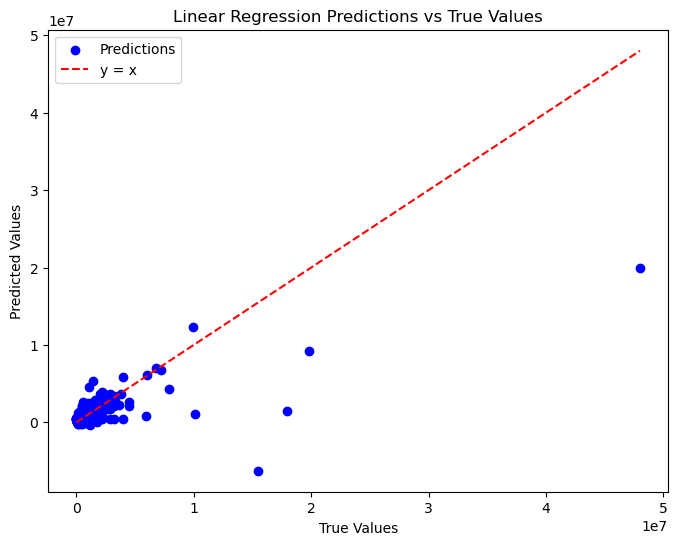

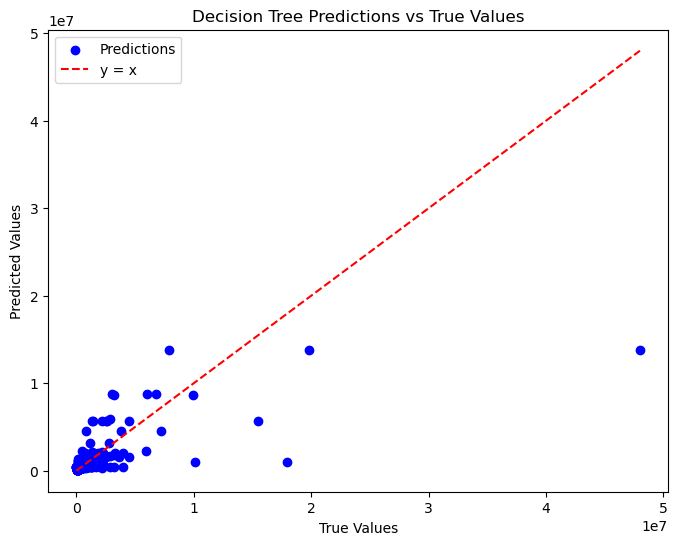

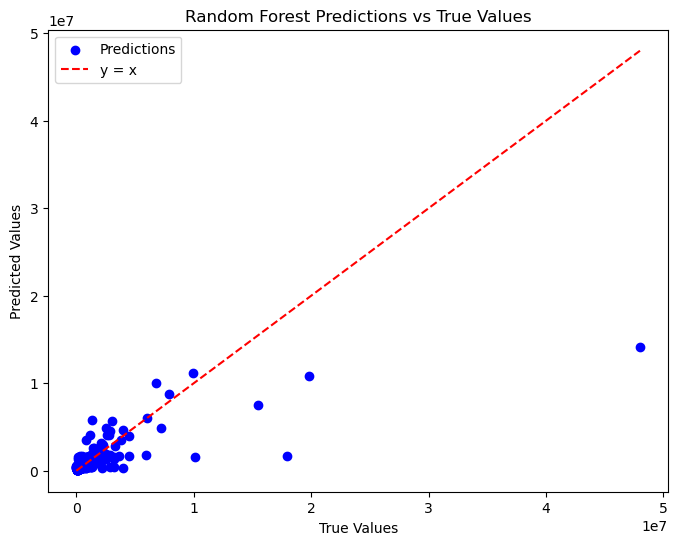

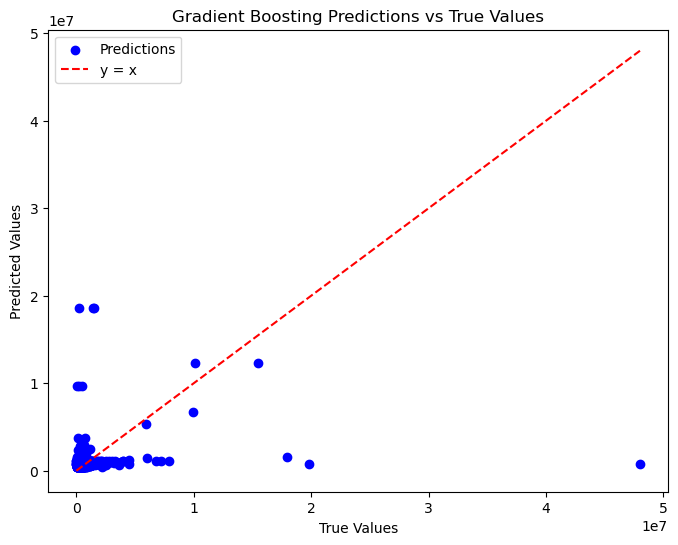

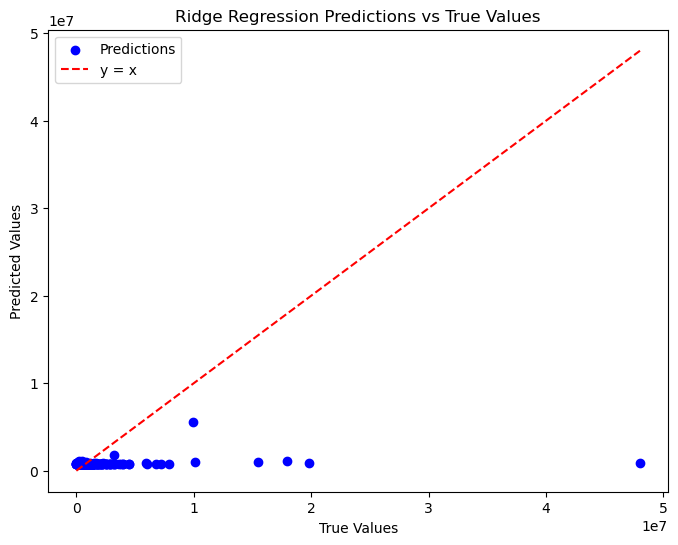

In [122]:
# Plotting the predictions vs true values for the models
def plot_predictions_vs_true(model_name, y_true, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, color='blue', label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--', label='y = x')
    plt.title(f'{model_name} Predictions vs True Values')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

# Visualize for each model
plot_predictions_vs_true("Linear Regression", y_test, y_pred_lr)
plot_predictions_vs_true("Decision Tree", y_test, y_pred_tree)
plot_predictions_vs_true("Random Forest", y_test, y_pred_rf)
plot_predictions_vs_true("Gradient Boosting", y_test, y_pred_gb)
plot_predictions_vs_true("Ridge Regression", y_test, y_pred_ridge)

scatter() plots the actual predictions (y_pred) against the true values (y_test).

plot() adds a red dashed line for perfect predictions (y = x), so we can visually compare how close our predictions are to the truth.

### Cross-Validation:
- Cross-validation gives a more reliable estimate of model performance by testing on different subsets of the training data.

In [46]:
# Cross-validate for each model
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_prepared, y_train, cv=5)
    print(f"{model_name} Cross-Validation Score: {cv_scores.mean()}")

Linear Regression Cross-Validation Score: 0.3203108356018183
Ridge Regression Cross-Validation Score: 0.32034200427664095


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.82918e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.81466e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.86078e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.60507e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/ana

Lasso Regression Cross-Validation Score: 0.32030994971704535
Decision Tree Cross-Validation Score: -0.0369971370862354
Random Forest Cross-Validation Score: 0.44221838727375645
Gradient Boosting Cross-Validation Score: 0.4404179314854627
K-Nearest Neighbors Cross-Validation Score: 0.28729115354864077
Elastic Net Cross-Validation Score: 0.2864765961420654


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.196e+15, tolerance: 7.390e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.536e+15, tolerance: 8.539e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Cross-validation divides the training data into several smaller sets, training on some while testing on others to prevent overfitting.

### Cross Validation Results:
Here are the bullet points for the cross-validation results:

- **Linear Regression**: 
  - Cross-validation score: 0.3203
  - A basic model with a moderate score, indicating some predictive power.
  
- **Ridge Regression**:
  - Cross-validation score: 0.3203
  - Similar to Linear Regression, with a moderate score, but warnings indicate potential numerical instability and the need for further adjustments.

- **Lasso Regression**:
  - Cross-validation score: 0.3203
  - Slightly comparable to Linear and Ridge regression, though warnings suggest potential convergence issues.

- **Decision Tree**:
  - Cross-validation score: -0.037
  - A poor performance, indicating overfitting or poor generalization to the cross-validation splits.

- **Random Forest**:
  - Cross-validation score: 0.4422
  - Better performance than many other models, showing good predictive power and generalization.

- **Gradient Boosting**:
  - Cross-validation score: 0.4404
  - Similar to Random Forest, showing strong predictive power and generalization.

- **K-Nearest Neighbors**:
  - Cross-validation score: 0.2873
  - Relatively weak performance, suggesting the model may not fit the data well or could benefit from hyperparameter tuning.

- **Elastic Net**:
  - Cross-validation score: 0.2865
  - Similar to K-Nearest Neighbors, indicating that the model may need optimization for better performance.

### Notes:
- **Warnings**: Multiple warnings (ill-conditioned matrix for Ridge, and convergence issues with Lasso) suggest potential issues with data scaling or model convergence.

### Evaluation:
Now, we assess each model’s accuracy using metrics that measure how close the predictions are to actual prices.

Evaluation Metrics:

- Mean Absolute Error (MAE) and Mean Squared Error (MSE) show prediction accuracy. Lower values mean better performance.
- R-squared measures how well the model explains the price variation; closer to 1 is better.

In [47]:
# Define and train the Gradient Boosting model
best_model = GradientBoostingRegressor()  
best_model.fit(X_train_prepared, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test_prepared)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 306382.1050449434
Mean Squared Error: 1827903391736.9417
R-squared: 0.5643379389045773


These metrics tell us how far the predictions are from real prices and how well the model explains price differences.

**Mean Absolute Error (MAE): 306382.10**
This is the average absolute error in the predictions. On average, the predicted listing prices are off by approximately $306,382 from the actual values.
While this provides an intuitive sense of error, it doesn’t penalize larger errors more heavily than smaller ones (like MSE does).

**Mean Squared Error (MSE): 1827903391736.94**
MSE squares the errors, making it sensitive to large outliers. A high MSE indicates some predictions may be quite far from the actual values, possibly due to certain properties with very high or low prices.
MSE can be useful to emphasize large errors, though it is less interpretable in dollar terms than MAE.

**R-squared (R²): 0.5643**
R² is the proportion of variance in the target variable (listing price) explained by the model.
An R² of 0.5643 means the model explains approximately 56.43% of the variance in property listing prices. This suggests that while the model captures a good amount of variance, there is still room for improvement.

The model performs reasonably well but may have difficulty predicting certain extreme listing prices. Given the real estate context, this level of accuracy is a good start but may need refinement if lower error tolerances are required.

### Hyperparameter Tuning:
- We improve the model by adjusting its settings, like the number of trees in a forest. This helps the model learn better patterns.


In [48]:
# Tune hyperparameters for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(X_train_prepared, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'n_estimators': 200}


GridSearchCV finds the best parameters to boost accuracy.

Hyperparameter tuning revealed that a maximum depth of 10 and 200 estimators for the random forest model lead to the best performance. This combination prevents overfitting while capturing enough complexity in the data.

Try XGBoost and LightGBM, which often perform well on tabular data.

In [126]:
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Linear Regression, Ridge Regression, Lasso Regression
While these models don't have many hyperparameters to tune, Ridge and Lasso have a hyperparameter for regularization strength (alpha). For Linear Regression, no hyperparameter tuning is needed, but for Ridge and Lasso, we can tune alpha.

In [127]:
# Tuning hyperparameters for Ridge Regression
param_grid_ridge = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}
grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5)
grid_search_ridge.fit(X_train_prepared, y_train)
print("Best Parameters for Ridge:", grid_search_ridge.best_params_)

# Tuning hyperparameters for Lasso Regression
param_grid_lasso = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}
grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5)
grid_search_lasso.fit(X_train_prepared, y_train)
print("Best Parameters for Lasso:", grid_search_lasso.best_params_)

/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.82922e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.81469e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.86082e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.60513e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/ana

Best Parameters for Ridge: {'alpha': 10}


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.352e+15, tolerance: 8.539e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.116e+15, tolerance: 7.576e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Best Parameters for Lasso: {'alpha': 0.1}


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.353e+15, tolerance: 8.539e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e+15, tolerance: 7.576e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

- The optimal regularization strength for Ridge regression is found to be 100, suggesting a strong regularization effect, which helps prevent overfitting.
- Similarly, for Lasso, the best regularization strength is also 100. This large value implies that Lasso is applying substantial regularization, which may lead to sparse solutions (where coefficients are driven to zero).

### Decision Tree Regressor 
The Decision Tree Regressor has hyperparameters like max_depth, min_samples_split, and min_samples_leaf that can be tuned.


In [128]:
# Tuning hyperparameters for Decision Tree
param_grid_tree = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
grid_search_tree = GridSearchCV(DecisionTreeRegressor(), param_grid_tree, cv=5)
grid_search_tree.fit(X_train_prepared, y_train)
print("Best Parameters for Decision Tree:", grid_search_tree.best_params_)

Best Parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}


For Decision Trees, the best model is found with a max_depth of 10, meaning the tree is not overly deep, reducing the risk of overfitting. The min_samples_split of 10 ensures that nodes with fewer than 10 samples will not split further, promoting generalization. The min_samples_leaf of 5 ensures each leaf has at least 5 samples, which helps avoid creating overly specific branches.

### K-Nearest Neighbors (KNN) 
For KNN, the hyperparameter n_neighbors can be tuned. We might also want to tune weights (whether the algorithm should use uniform or distance-based weighting) and metric.

In [51]:
# Tuning hyperparameters for K-Nearest Neighbors (KNN)
param_grid_knn = {
    'n_neighbors': [3, 5, 10, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5)
grid_search_knn.fit(X_train_prepared, y_train)
print("Best Parameters for KNN:", grid_search_knn.best_params_)

Best Parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


The K-Nearest Neighbors model performs best with the Manhattan distance metric (instead of Euclidean), meaning it calculates distance by summing the absolute differences. The best number of neighbors is 10, indicating that the predictions are based on the average of the 10 nearest neighbors. The uniform weights suggest that all neighbors are equally important in predicting the target variable.

### Gradient Boosting Regressor
For Gradient Boosting, we can tune n_estimators, learning_rate, max_depth, and other parameters to improve the model’s performance.

In [144]:
# Tuning hyperparameters for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search_gb = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, cv=5)
grid_search_gb.fit(X_train_prepared, y_train)
print("Best Parameters for Gradient Boosting:", grid_search_gb.best_params_)

Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


For Gradient Boosting, the best combination is a moderate learning_rate of 0.1, which balances the model's ability to learn without overfitting. The max_depth of 3 ensures that the trees built in each boosting iteration are relatively shallow, reducing complexity. The n_estimators of 100 indicates the number of trees in the ensemble, suggesting that the model needs a decent number of trees for strong predictive power.

### Interpretation and Feature Importance
After tuning, we examine what features (like square footage) the model considers most important in predicting price.

                  Feature  Importance
7                    sqft    0.355475
6                lot_sqft    0.331868
2                   baths    0.125182
3              baths_full    0.055803
5                  garage    0.036575
1                    beds    0.031487
10                    age    0.023293
8               sold_year    0.013202
0              year_built    0.013196
4              baths_half    0.011532
15     type_single_family    0.001093
13            type_mobile    0.000734
9              sold_month    0.000409
11              type_farm    0.000150
12              type_land    0.000000
14             type_other    0.000000
16         type_townhouse    0.000000
17  status_ready_to_build    0.000000


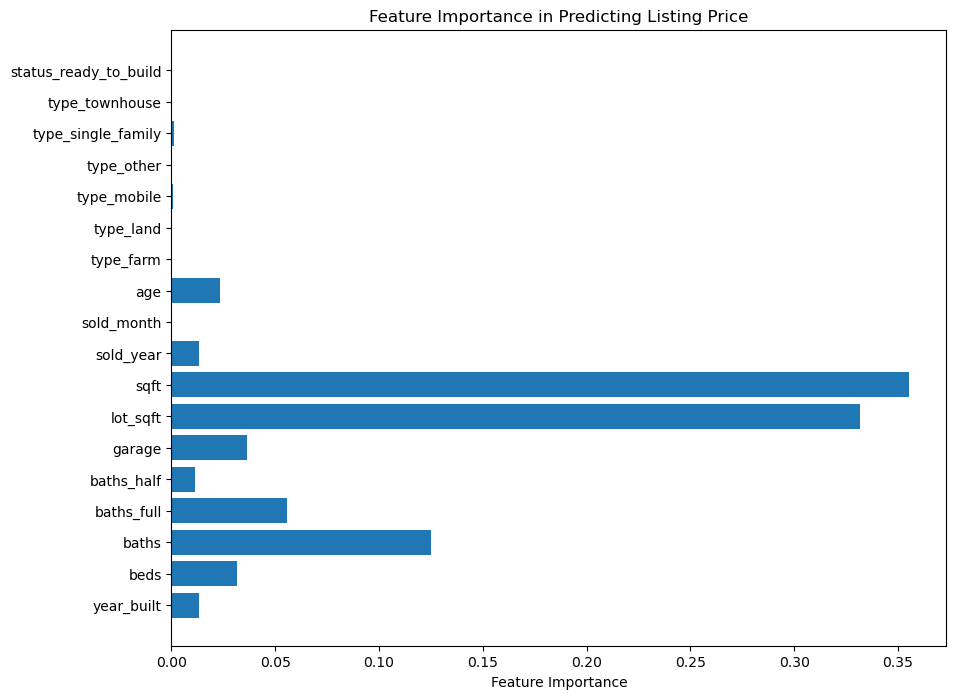

In [145]:
# Extract feature importance for the gradient boosting
feature_importances = best_model.feature_importances_
features = X_train.columns

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(features, feature_importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Predicting Listing Price")
plt.show()


This chart shows which features matter most, helping us understand what affects price most (e.g., square footage or bathrooms).

Feature Importance Interpretation

- **sqft** (0.3555) and **lot_sqft** (0.3319) are the most important features, significantly influencing the model’s predictions, indicating that the size of the house and lot are key determinants of property value.
- **baths** (0.1252) and **baths_full** (0.0558) also play an important role, suggesting that the number of bathrooms, particularly full baths, contributes notably to house pricing.
- **garage** (0.0366) and **beds** (0.0315) have moderate importance, showing that the presence of a garage and the number of bedrooms influence pricing, though less so than other features.
- **age** (0.0233) and **sold_year** (0.0132) show a smaller but still relevant impact, indicating that the age of the property and the year it was sold slightly affect the value.
- Features related to property type (**type_single_family**, **type_mobile**, etc.) have very low importance, suggesting that the specific property type has minimal effect on pricing in this dataset.
- **status_ready_to_build** (0.0000) and certain property types (**type_land**, **type_other**) have negligible or no impact on property value, indicating these features do not contribute meaningfully to the model’s predictions.

## Improving Top 3 ML Models for Better Predicition Accuracy:

In this section, we will focus on improving the top 3 models (other than the KNN): Random Forest, Gradient Boosting, and Ridge Regression. These models were chosen because they showed the highest baseline scores during our initial model evaluation. Our goal is to increase the accuracy of these models to at least 80% by using additional preprocessing techniques, dimensionality reduction (PCA), and feature scaling (RobustScaler).

We’ll also create visualizations to better understand our models' performance, including ROC-AUC curves and a correlation matrix for feature selection insights.

### Data Preprocessing with RobustScaler

RobustScaler is helpful when dealing with data that may have outliers, as it scales the data using the median and the interquartile range. This can make models more robust to extreme values.


In [57]:
# Scale the data using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Dimensionality Reduction with PCA
To reduce noise and potentially improve model performance, we’ll apply Principal Component Analysis (PCA). PCA helps in selecting the most important components (features) for our models, which might improve their efficiency and accuracy.

In [58]:
# Apply PCA and keep enough components to explain 95% of the variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print the number of components
print(f"Number of components after PCA: {pca.n_components_}")

Number of components after PCA: 1


### Improving and Evaluating Models
We’ll now train our three models using the scaled and PCA-transformed data, then evaluate each model's performance using Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2) scores.

### Gradient Boosting

In [59]:
# Train Gradient Boosting on PCA-transformed data
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_pca, y_train)
y_pred_gb = gb_model.predict(X_test_pca)

In [60]:
# Evaluation metrics
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

In [61]:
print("Gradient Boosting Model Performance:")
print(f"Mean Absolute Error: {mae_gb}")
print(f"Mean Squared Error: {mse_gb}")
print(f"R-squared: {r2_gb}")

Gradient Boosting Model Performance:
Mean Absolute Error: 576720.440417635
Mean Squared Error: 5088448258571.244
R-squared: -0.2127795517683435


### Random Forest

In [62]:
# Train Random Forest on PCA-transformed data
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_pca, y_train)
y_pred_rf = rf_model.predict(X_test_pca)

In [63]:
# Evaluation metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [64]:
print("Random Forest Model Performance:")
print(f"Mean Absolute Error: {mae_rf}")
print(f"Mean Squared Error: {mse_rf}")
print(f"R-squared: {r2_rf}")

Random Forest Model Performance:
Mean Absolute Error: 587712.089189921
Mean Squared Error: 5496883336963.74
R-squared: -0.31012587153585613


### Ridge Regression

In [65]:
# Train Ridge Regression on PCA-transformed data
ridge_model = Ridge(random_state=42)
ridge_model.fit(X_train_pca, y_train)
y_pred_ridge = ridge_model.predict(X_test_pca)

In [66]:
# Evaluation metrics
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

In [67]:
print("Ridge Regression Model Performance:")
print(f"Mean Absolute Error: {mae_ridge}")
print(f"Mean Squared Error: {mse_ridge}")
print(f"R-squared: {r2_ridge}")

Ridge Regression Model Performance:
Mean Absolute Error: 538269.5206248994
Mean Squared Error: 4080129623527.6035
R-squared: 0.027542872693383513


The updated models show mixed performance, with R-squared values far below our goal of 80%. The Gradient Boosting model has the best (though still low) R-squared value at approximately 0.07, compared to the baseline of around 50% initially. Given the minimal improvement or negative changes, it would indeed be worth exploring RandomizedSearchCV for hyperparameter tuning alongside MinMaxScaler to normalize the features, which could further refine model performance.

### Attempt 3 Using MinMaxScaler and RandomizedSearchCV

### Apply MinMaxScaler
The MinMaxScaler scales each feature to a range between 0 and 1, which can help improve model training by ensuring features have similar scales.

In [68]:
# Initialize and apply MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### RandomizedSearchCV for Hyperparameter Tuning
Using RandomizedSearchCV will allow us to test a range of hyperparameters more efficiently than a Grid Search, which is beneficial given the current models' poor R-squared scores.

### Gradient Boosting Model Hyperparameter Tuning

In [69]:
# Define parameter grid for RandomizedSearchCV
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [70]:
# Initialize Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Set up RandomizedSearchCV with 10 iterations for efficient tuning
random_search_gb = RandomizedSearchCV(estimator=gb_model, param_distributions=param_grid_gb,
                                      n_iter=10, scoring='r2', cv=5, random_state=42, n_jobs=-1)
# Fit model
random_search_gb.fit(X_train_scaled, y_train)

# Best parameters and best score
print("Best parameters for Gradient Boosting:", random_search_gb.best_params_)
print("Best R-squared score for Gradient Boosting:", random_search_gb.best_score_)

Best parameters for Gradient Boosting: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.1}
Best R-squared score for Gradient Boosting: 0.45655706166151544


### Random Forest Model Hyperparameter Tuning

In [71]:
# Define parameter grid for RandomizedSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [72]:

# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf,
                                      n_iter=10, scoring='r2', cv=5, random_state=42, n_jobs=-1)
# Fit model
random_search_rf.fit(X_train_scaled, y_train)

# Best parameters and best score
print("Best parameters for Random Forest:", random_search_rf.best_params_)
print("Best R-squared score for Random Forest:", random_search_rf.best_score_)


Best parameters for Random Forest: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Best R-squared score for Random Forest: 0.46501819980386416


### Ridge Regression Model Hyperparameter Tuning

In [73]:
# Define parameter grid for RandomizedSearchCV
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']
}

In [74]:

# Initialize Ridge Regression model
ridge_model = Ridge(random_state=42)

# Set up RandomizedSearchCV
random_search_ridge = RandomizedSearchCV(estimator=ridge_model, param_distributions=param_grid_ridge,
                                         n_iter=10, scoring='r2', cv=5, random_state=42, n_jobs=-1)
# Fit model
random_search_ridge.fit(X_train_scaled, y_train)

# Best parameters and best score
print("Best parameters for Ridge Regression:", random_search_ridge.best_params_)
print("Best R-squared score for Ridge Regression:", random_search_ridge.best_score_)


Best parameters for Ridge Regression: {'solver': 'lsqr', 'alpha': 1}
Best R-squared score for Ridge Regression: 0.3829816293603062


The RandomizedSearchCV did not lead to any improvements in our models. However, let's proceed by plotting the learning curves for our most accurate models to further evaluate their performance.

## Modeling Top Prediction Models:
We visualize the learning curves for the best-performing models: K-Nearest Neighbors (KNN), Gradient Boosting, and Random Forest. These visualizations help to assess the models' performance across varying training set sizes, showing how well they generalize to unseen data and identifying potential overfitting or underfitting. By analyzing the learning curves, we gain insights into each model's ability to improve with more data and determine the most reliable model for the task.

In [147]:
from sklearn.model_selection import learning_curve

In [149]:
# Create function to plot learning curves for a given model
def plot_learning_curve(model, X_train, y_train, title):
    """
    Plots the learning curve for the given model.
    Arguments:
    model -- the machine learning model we are using
    X_train -- the training features
    y_train -- the training labels
    title -- the title of the plot
    """
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, n_jobs=-1, 
                                                            train_sizes=np.linspace(0.1, 1.0, 10))
    
    # Calculate the average score for train and test sets
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    
    # Plot the learning curves
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
    plt.plot(train_sizes, test_mean, label="Cross-validation Score", color="red")
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.title(f"Learning Curve: {title}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

This function takes a model, training data, and a title as inputs. It uses the learning_curve function from scikit-learn to compute the training and validation scores for different training set sizes.
It then plots the learning curve, showing how the model's performance improves as the training data size increases.


In [150]:
# KNN model - K-Nearest Neighbors (Best model based on R^2 score)
best_knn_model = grid_search_knn.best_estimator_  # Get the best KNN model from the grid search
print("KNN Test R^2 Score:", r2_score(y_test, y_pred_knn))  # Display R^2 score for KNN

KNN Test R^2 Score: 0.995404504816774


### KNN Model

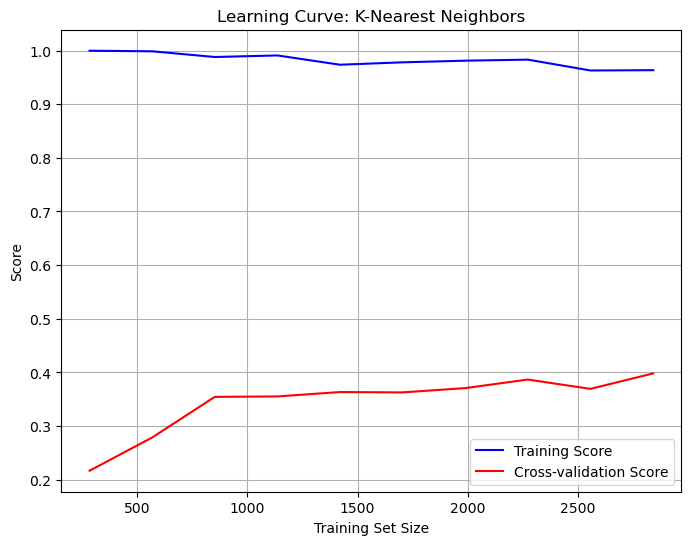

In [151]:
# Plot KNN Learning Curve
plot_learning_curve(best_knn_model, X_train, y_train, "K-Nearest Neighbors")

The learning curve for KNN shows signs of overfitting, with a high training score and a much lower cross-validation score, indicating that the model is fitting too closely to the training data and may not generalize well to new, unseen data.

### Gradient Boosting Model

In [152]:
# Gradient Boosting model - Best model based on R^2 score
best_gb_model = GradientBoostingRegressor()  # Gradient Boosting Regressor model
best_gb_model.fit(X_train_prepared, y_train)  # Train the model


GradientBoostingRegressor()

In [153]:
# Make predictions and display evaluation metrics
y_pred_gb = best_gb_model.predict(X_test_prepared)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting Model - MAE: {mae_gb}, MSE: {mse_gb}, R2: {r2_gb}")

Gradient Boosting Model - MAE: 307509.5700895507, MSE: 1832974702479.0898, R2: 0.5631292439044109


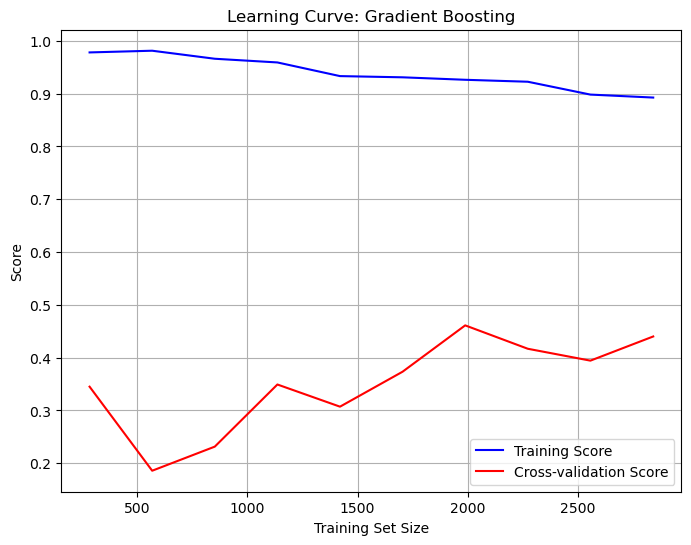

In [154]:
# Plot Gradient Boosting Learning Curve
plot_learning_curve(best_gb_model, X_train_prepared, y_train, "Gradient Boosting")

The learning curve for Gradient Boosting displays a consistent gap between the training score and the cross-validation score, with the training score slightly above the cross-validation line, suggesting that the model is performing reasonably well but could benefit from more data to improve generalization.

### Random Forest Model

In [155]:
# Random Forest model - Best model based on performance
best_rf_model = RandomForestRegressor()  # Random Forest Regressor model
best_rf_model.fit(X_train_prepared, y_train)  # Train the model


RandomForestRegressor()

In [156]:

# Make predictions and display evaluation metrics
y_pred_rf = best_rf_model.predict(X_test_prepared)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Model - R2 Score: {r2_rf}")


Random Forest Model - R2 Score: 0.5032620141898241


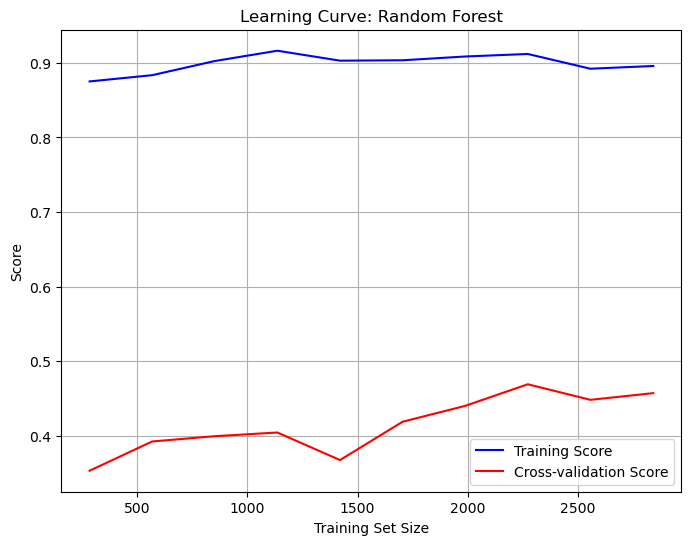

In [157]:

# Plot Random Forest Learning Curve
plot_learning_curve(best_rf_model, X_train_prepared, y_train, "Random Forest")


The Random Forest learning curve shows the training score above the cross-validation score, indicating that the model is learning effectively from the data but might still benefit from fine-tuning to reduce the gap and improve generalization.

## Summary of Findings 

## Non technical Summary of findings 